# Introduction

In this notebook, we perform a full time series analysis on the S&P 500 index using real-world data. We explore key components of time series data including trend, seasonality, and stationarity. We also apply smoothing techniques and build predictive models to forecast future values.

Throughout this analysis, we leverage the powerful [Statsmodels library](https://www.statsmodels.org/stable/tsa.html), particularly its tsa (time series analysis) module, which provides tools for decomposition, stationarity testing, autocorrelation analysis, and ARIMA-based modeling.

Our overall goal is to gain a deeper understanding of the S&P 500's historical behavior and construct a forecasting model that captures its underlying dynamics.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Let's load the data that we will be working with.


In [ ]:
# Load the index (overall S&P 500 performance)
index_df = pd.read_csv('/content/drive/MyDrive/sp500_index.csv')

In [ ]:
index_df.head()

,Date,S&P500
0,2014-12-22,2078.54
1,2014-12-23,2082.17
2,2014-12-24,2081.88
3,2014-12-26,2088.77
4,2014-12-29,2090.57


In [ ]:
len(index_df) # 10+ years = 2517 business days

2517

In time series analysis, it is essential to organize the dataset chronologically.
To facilitate this, we set the `Date` column as the DataFrame index.

Using the date as the index allows us to:
- Ensure that the data is properly ordered in time.
- Easily slice and filter the data by specific time periods.
- Apply time series methods (like differencing, rolling averages, and resampling) that expect a datetime index.
- Plot the data against time automatically, without needing to specify the x-axis manually.

Indexing by date transforms the dataset from a regular table into a true time series object, enabling the use of specialized forecasting models and time-aware calculations.


In [ ]:
index_df['Date'] = pd.to_datetime(index_df['Date'])
index_df.set_index('Date', inplace=True) #indexing it by time

In [ ]:
index_df.head() # check our work !

,S&P500
Date,
2014-12-22,2078.54
2014-12-23,2082.17
2014-12-24,2081.88
2014-12-26,2088.77
2014-12-29,2090.57


## Visualizing the Time Series

Now that we have prepared our dataset and indexed it by date,
let’s take a look at how the S&P 500 index behaves over time by graphing it as a time series.
This visualization will help us identify any obvious trends, seasonality, or irregularities at a glance.

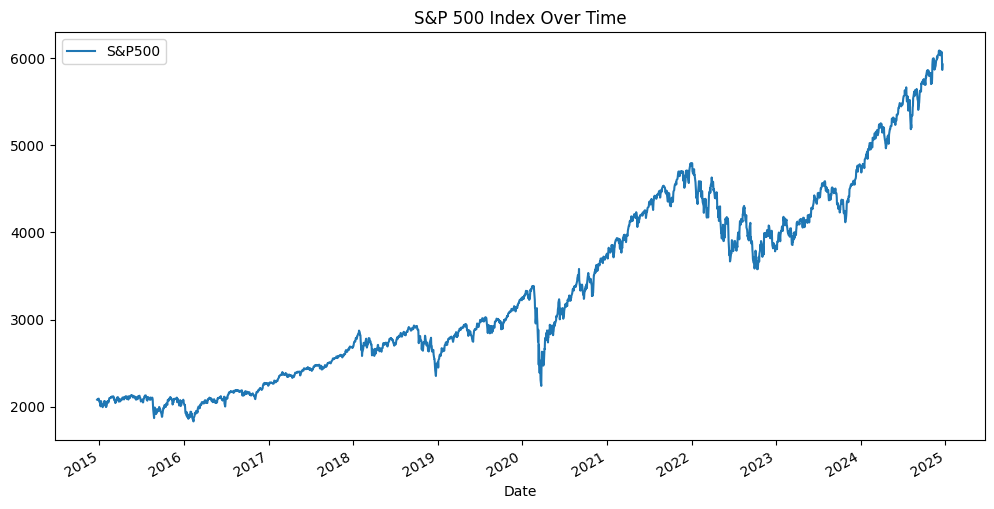

In [ ]:
ax = index_df.plot(
    y='S&P500',
    figsize=(12,6),
    title='S&P 500 Index Over Time',
    grid=False
)

fig = ax.get_figure()
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

plt.show()

The graph above shows the performance of the S&P 500 index over the last decade.

While there has been a strong overall upward trend across the decade, for the purpose of this notebook, we will specifically focus on the period following the COVID-19 market crash in early 2020.

This period represents a significant and rapid recovery, where the S&P 500 rebounded sharply after a historic drop.
By narrowing our analysis to this recovery phase, we can more closely examine how the market behaves after major economic shocks, and evaluate how well time series models can capture and predict this type of recovery pattern.

Focusing on this recovery period will allow us to build more relevant and targeted forecasts for the recent behavior of the market.


In [ ]:
# Make sure the index is datetime
index_df.index = pd.to_datetime(index_df.index)

# Filter data for post 2020
index_5_df = index_df[index_df.index >= '2020-01-01']

In [ ]:
index_5_df.head() # check our work

,S&P500
Date,
2020-01-02,3257.85
2020-01-03,3234.85
2020-01-06,3246.28
2020-01-07,3237.18
2020-01-08,3253.05


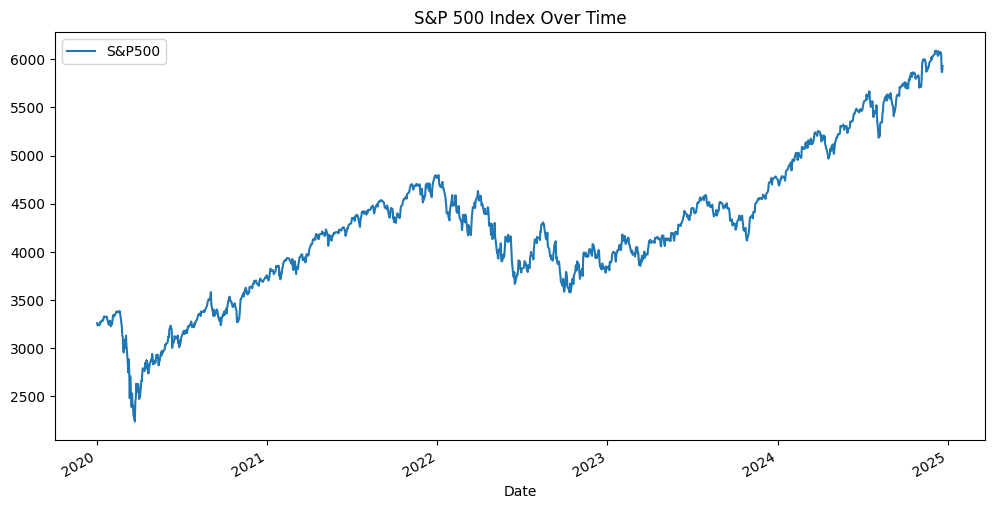

In [ ]:
ax = index_5_df.plot(
    y='S&P500',
    figsize=(12,6),
    title='S&P 500 Index Over Time',
    grid=False
)

fig = ax.get_figure()
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

plt.show()

## Components of a Time Series

To better understand the behavior of the S&P 500 index, we can break down the time series into three key components:

- **Trend**: The long-term progression of the series, showing overall growth or decline.
- **Seasonality**: Regular, repeating patterns or cycles within fixed periods (such as yearly market behaviors).
- **Residuals (Noise)**: Random variation that cannot be attributed to trend or seasonality.

We perform this decomposition using the `seasonal_decompose()` function from the `statsmodels` library. This function separates the time series into its underlying components based on a specified period.

For financial data like the S&P 500, we assume an **additive model** (where components add together), and we set the **period to 252** to correspond to the approximate number of trading days in a year.

By analyzing each component individually, we gain valuable insights into the predictable and unpredictable elements of the market's movement. This understanding will help guide our modeling and forecasting decisions later in the analysis.


In [ ]:
# Decompose the recent data
decomposition_recent = seasonal_decompose(
    index_5_df['S&P500'], # target column
    model='additive',  # components add together
    period=252         # ~252 trading days/year for stocks
)

# Extract components
trend_recent = decomposition_recent.trend
seasonal_recent = decomposition_recent.seasonal
residual_recent = decomposition_recent.resid

Let's take a look at the trend in our data.

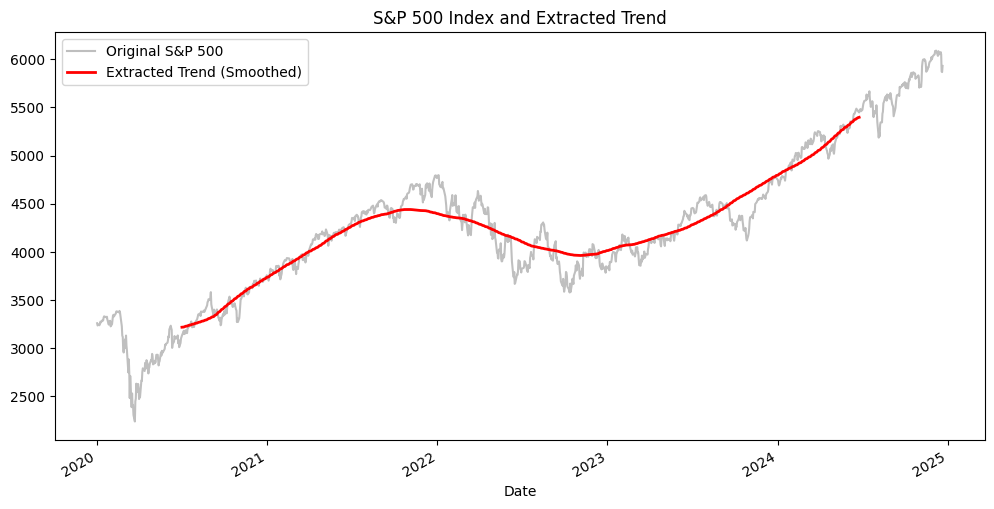

In [ ]:
# plot trend component
fig, ax = plt.subplots(figsize=(12,6))
index_5_df['S&P500'].plot(ax=ax, label='Original S&P 500', color='gray', alpha=0.5)
trend_recent.plot(ax=ax, label='Extracted Trend (Smoothed)', color='red', linewidth=2)
ax.set_title('S&P 500 Index and Extracted Trend')
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.legend()
plt.show()

The plot above shows the original S&P 500 index overlaid with the extracted trend component obtained from seasonal decomposition.

The trend line captures the general long-term movement of the index without the influence of short-term fluctuations or seasonal effects. From 2020 onward, we observe a period of steep growth, a noticeable dip around 2022 corresponding to market volatility, and a subsequent recovery leading into 2024 and beyond.

Importantly, the extracted trend is **not perfectly linear**. It naturally curves and adjusts to changing market conditions, demonstrating how real-world financial data often experience periods of acceleration and deceleration rather than following a constant growth rate.

By isolating and analyzing the trend component separately, we can better understand the underlying growth trajectory of the market. This insight is crucial for building more reliable forecasting models, as it allows us to focus on the sustained direction of the market rather than being distracted by temporary noise. Next, we will examine the seasonal component.


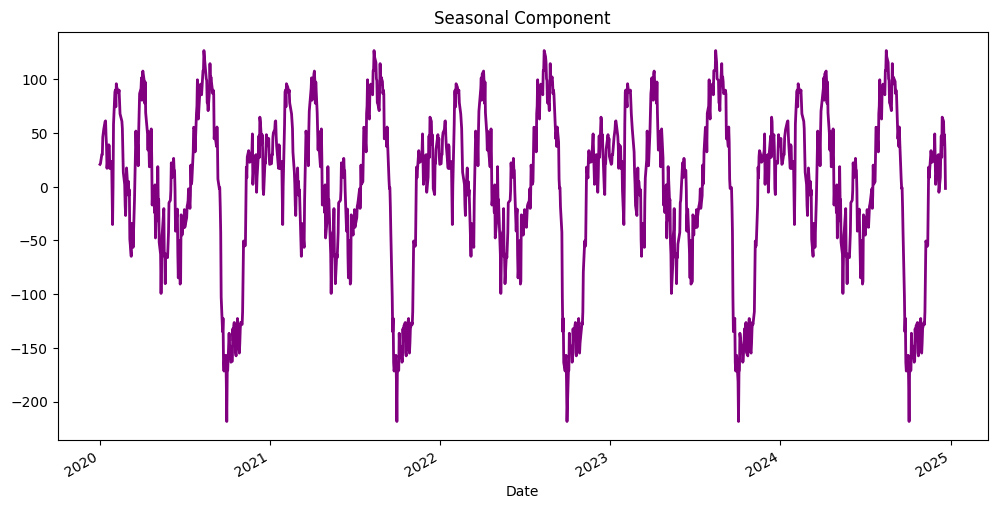

In [ ]:
# plot seasonal component
fig, ax = plt.subplots(figsize=(12,6))
seasonal_recent.plot(ax=ax, color='purple', linewidth=2)
ax.set_title('Seasonal Component')
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.show()

The plot above displays the seasonal component extracted from the S&P 500 time series.

Seasonality refers to patterns that repeat at regular intervals over time. In this case, the extracted seasonal component highlights consistent fluctuations throughout the year, consistent with the behavior often observed in financial markets. These patterns can be attributed to recurring market phenomena such as tax seasons, fiscal year closings, holiday spending effects, and investor behavior around calendar milestones.

It is important to note that the amplitude (height) of the seasonal effects remains relatively stable over time, justifying our earlier decision to apply an additive model for decomposition. The presence of seasonality indicates that part of the variation in the S&P 500 index is predictable and tied to the calendar cycle, independent of the broader economic trend.

Understanding and accounting for seasonality is critical in time series analysis, as it allows us to improve forecasting accuracy by separating systematic cyclical behavior from random noise and long-term movements. Lastly, let's move on to the residual component.


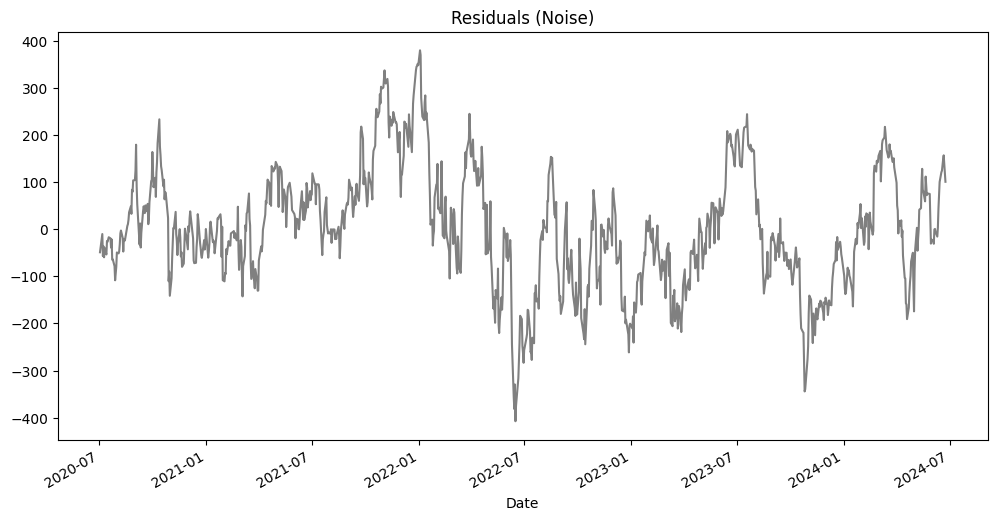

In [ ]:
# plot residuals component
fig, ax = plt.subplots(figsize=(12,6))
residual_recent.plot(ax=ax, color='gray')
ax.set_title('Residuals (Noise)')
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.show()

The plot above shows the residual component of the S&P 500 time series after removing the trend and seasonality.

Residuals, also referred to as noise, capture the irregular, unpredictable variations in the data that are not explained by the long-term trend or repeating seasonal patterns. These random fluctuations are often the result of unexpected economic events, geopolitical developments, investor sentiment changes, or other unforeseen shocks to the market.

Ideally, residuals should resemble a random pattern centered around zero, without clear trends or repeating cycles. This would indicate that the primary structure of the time series has been effectively captured by the trend and seasonal components.

In this case, while the residuals are relatively centered around zero, we can still observe periods of larger volatility, especially around known periods of market stress. This highlights the importance of accounting for potential variability and uncertainty when building forecasting models.

Analyzing the residuals helps validate whether our decomposition successfully isolated meaningful structure from random noise — an important check before proceeding to predictive modeling.

# Smoothing

## Simple Moving Average

Before building forecasting models, it is often helpful to smooth the original time series. Smoothing reduces short-term fluctuations and highlights the underlying trend more clearly.

One common smoothing technique is the **Simple Moving Average (SMA)**. The SMA replaces each data point with the average of its neighboring points over a specified window, helping to filter out noise and volatility.

In this analysis, we apply a **30-day moving average** to the S&P 500 index, corresponding roughly to one month of trading activity. This allows us to better observe medium-term trends while minimizing daily market noise.


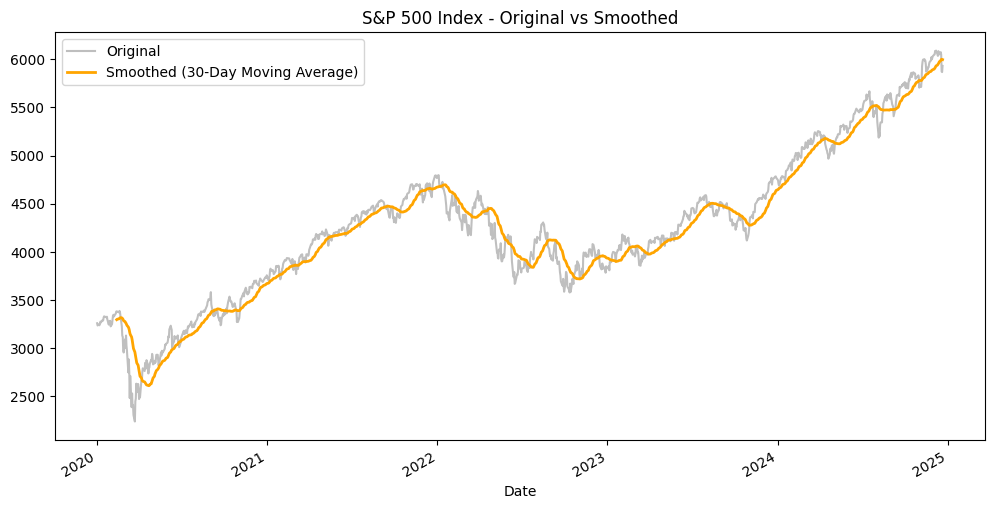

In [ ]:
# smooth using a simple moving average
smoothed = index_5_df['S&P500'].rolling(window=30).mean()

# plot original vs smoothed to compare
fig, ax = plt.subplots(figsize=(12,6))

index_5_df['S&P500'].plot(ax=ax, alpha=0.5, label='Original', color='gray')
smoothed.plot(ax=ax, label='Smoothed (30-Day Moving Average)', color='orange', linewidth=2)

ax.set_title('S&P 500 Index - Original vs Smoothed')
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.legend()
plt.show()


The plot above compares the original S&P 500 index with its smoothed version using a 30-day moving average.

As expected, the smoothed line (orange) follows the overall shape of the original series but with significantly less volatility. Short-term fluctuations and random noise are minimized, revealing a clearer view of the underlying trend over time.

Smoothing techniques like the moving average are particularly useful for:
- Identifying major turning points in the market,
- Reducing the influence of daily market noise,
- Providing a simplified version of the data for basic forecasting.

However, it is important to note that smoothing can introduce a lag, meaning that changes in the smoothed series may respond slightly after real changes occur in the original series. Thus, while smoothing helps in understanding trends, it must be used carefully when predicting future values.



### Simple Moving Average Forecasting

Now that we have smoothed the S&P 500 time series using a 30-day moving average, we can attempt a basic forecasting approach.

Using the last available smoothed value, we extend a simple forecast assuming that the next period's value will remain relatively stable at the last observed level. While this is a very basic method and does not account for future trends or volatility, it serves as a first step in generating naive forecasts based on historical smoothing.

In this case, we forecast the next 66 business days (approximately three months) by holding the last smoothed value constant into the future.


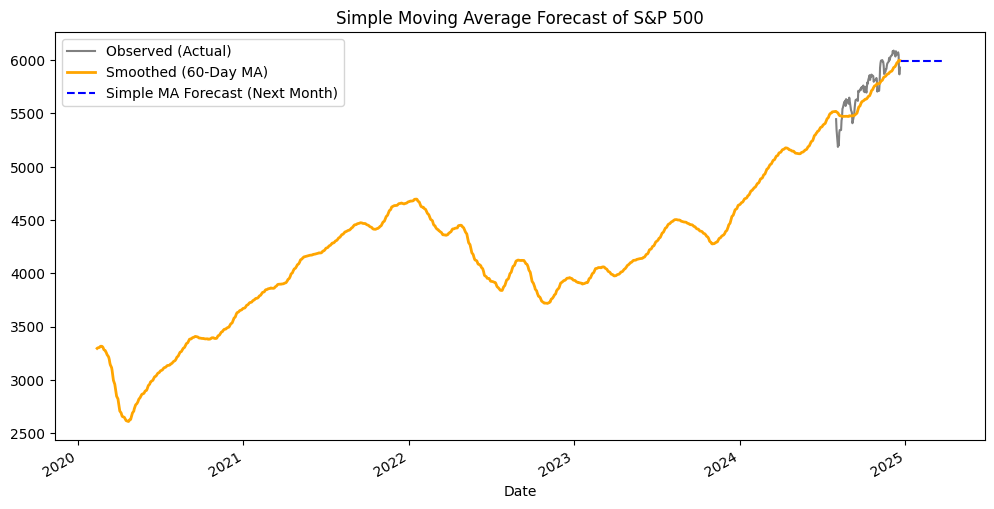

In [ ]:
# get the last smoothed value
last_smoothed_value = smoothed.dropna().iloc[-1]  # dropna() because first few are NaN due to window


# extend forecast for next 66 business days (about 3 months)
n_steps = 66
future_dates = pd.date_range(start=index_5_df.index[-1] + pd.Timedelta(days=1), periods=n_steps, freq='B')

# create a flat forecast at last smoothed value
forecast_series = pd.Series(last_smoothed_value, index=future_dates)

# plot original, smoothed & forecast
fig, ax = plt.subplots(figsize=(12,6))

# plot recent actual S&P500 (last 100 points)
index_5_df['S&P500'].tail(100).plot(ax=ax, label='Observed (Actual)', color='gray')

# plot smoothed
smoothed.plot(ax=ax, label='Smoothed (60-Day MA)', color='orange', linewidth=2)

# plot forecast
forecast_series.plot(ax=ax, label='Simple MA Forecast (Next Month)', color='blue', linestyle='--')

ax.set_title('Simple Moving Average Forecast of S&P 500')
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.legend()
plt.show()

The plot above shows the actual observed S&P 500 index, the smoothed series using a 30-day moving average, and the simple forecast for the next three months.

As expected, because we are using a naive moving average forecast, the predicted values remain flat at the last smoothed level. This technique provides a basic, stable extension but does not capture future dynamics such as potential growth, downturns, or seasonality.

Simple moving average forecasts are most appropriate when the series is relatively stable without strong upward or downward trends. In cases like the S&P 500, where long-term trends and seasonal effects are important, more sophisticated forecasting models such as ARIMA, exponential smoothing, or machine learning-based approaches are typically needed for improved predictive accuracy.

Nevertheless, simple forecasts like this are useful as a baseline for comparison when evaluating the performance of more advanced forecasting methods.


## Weighted Moving Average (WMA)

While simple moving averages treat all data points equally within the window, a **Weighted Moving Average (WMA)** assigns different levels of importance (weights) to different observations. Typically, more recent data points are given higher weights because they may better reflect current market conditions.

In this example, we define custom weights over the last three days, emphasizing the most recent prices more heavily. This custom weighting allows the moving average to be more responsive to recent changes compared to the simple average.

Weighted moving averages are useful when we want our smoothing method to react faster to new information without fully ignoring past trends.

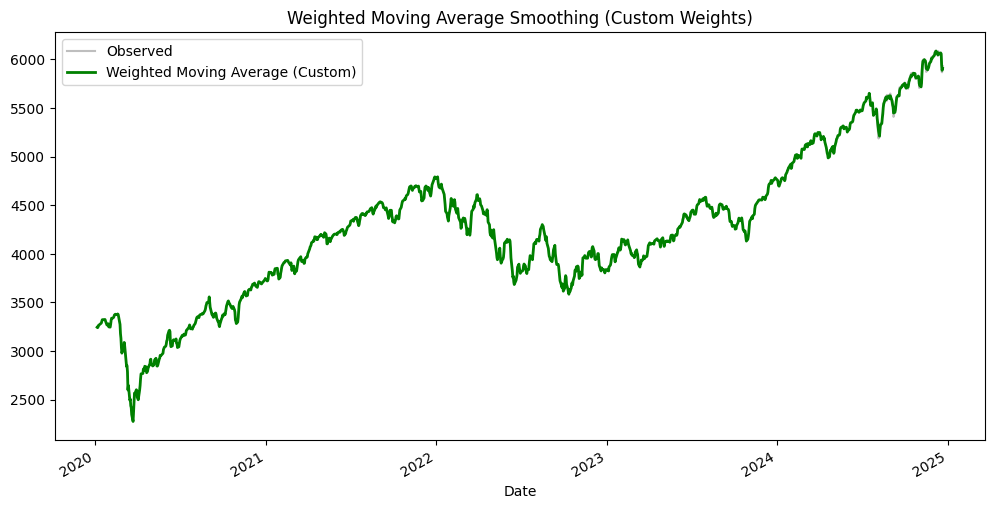

In [ ]:
# define weights for last 3 days as an example
weights = np.array([0.1, 0.3, 0.6])  # recent points are heavier
window_size = len(weights)

# custom  WMA function
def weighted_moving_average(series, weights):
    wma = series.rolling(window=window_size).apply(lambda prices: np.dot(prices, weights), raw=True)
    return wma

# apply WMA
wma_smoothed = weighted_moving_average(index_5_df['S&P500'], weights)

# plot
fig, ax = plt.subplots(figsize=(12,6))

index_5_df['S&P500'].tail(100).plot(ax=ax, alpha=0.5, label='Observed', color='gray')
wma_smoothed.plot(ax=ax, label='Weighted Moving Average (Custom)', color='green', linewidth=2)

ax.set_title('Weighted Moving Average Smoothing (Custom Weights)')
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.legend()
plt.show()

The plot above shows the S&P 500 index with a custom Weighted Moving Average (WMA) applied.

Compared to the simple moving average, the weighted moving average responds more quickly to changes in the underlying data, because it places greater emphasis on recent values. This results in a smoother curve that still reflects recent market movements more accurately than an equally weighted smoothing method.

Customizing the weights gives flexibility in tuning the responsiveness of the smoothing technique. Heavier weighting on recent points creates a curve that adapts faster to new trends but may also introduce more noise if weights are not chosen carefully.

In practice, WMAs are particularly useful in financial analysis when analysts want to detect turning points or momentum shifts earlier, while still filtering out excessive noise.

### Forecasting with Weighted Moving Average

After applying weighted smoothing to the S&P 500 index, we can extend a basic forecast using the Weighted Moving Average (WMA).

Similar to the simple moving average forecast, this approach assumes that the last smoothed value represents a stable expectation for the near future. Although this method does not predict growth or decline, it provides a quick way to extend the most recent trend forward.

Here, we forecast the next 66 business days (approximately three months) by holding the last WMA value constant.


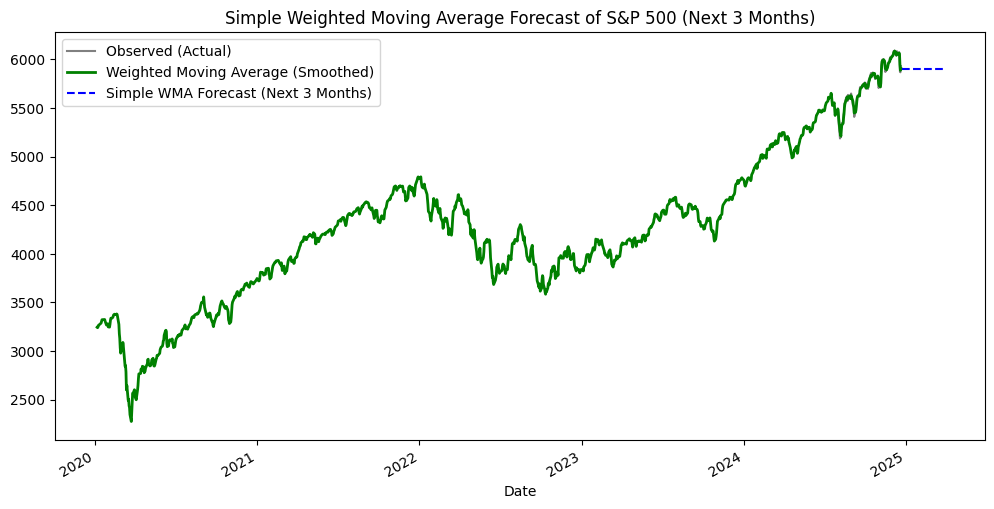

In [ ]:
# get the last weighted moving average value
last_wma_value = wma_smoothed.dropna().iloc[-1]

# forecast next 66 business days (~3 months)
n_steps = 66
future_dates = pd.date_range(start=index_5_df.index[-1] + pd.Timedelta(days=1), periods=n_steps, freq='B')

# create flat forecast series
forecast_wma = pd.Series(last_wma_value, index=future_dates)

# plot original, WMA smoothing, and forecast
fig, ax = plt.subplots(figsize=(12,6))

# plot observed data (last 100 points for context)
index_5_df['S&P500'].tail(100).plot(ax=ax, label='Observed (Actual)', color='gray')

# plot WMA smoothing
wma_smoothed.plot(ax=ax, label='Weighted Moving Average (Smoothed)', color='green', linewidth=2)

# plot forecast
forecast_wma.plot(ax=ax, label='Simple WMA Forecast (Next 3 Months)', color='blue', linestyle='--')

ax.set_title('Simple Weighted Moving Average Forecast of S&P 500 (Next 3 Months)')
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.legend()
plt.show()

The plot above shows the observed S&P 500 index, the weighted smoothed series, and the forecast for the next three months based on the last weighted value.

As expected from a moving average forecast, the predicted values remain flat at the most recent smoothed level. However, because the Weighted Moving Average reacts faster to recent price changes than the Simple Moving Average, it potentially captures more timely shifts in momentum.

While this naive approach provides a useful baseline, it does not account for expected growth trends, seasonal effects, or future uncertainty. In real-world forecasting applications, more sophisticated models would typically be used to project the path of the S&P 500 more accurately.

Nevertheless, weighted moving average forecasts offer a simple yet powerful first step in smoothing volatile data and extending short-term predictions.

## Conclusion on Smoothing Techniques

While simple and weighted moving averages provide valuable insights into the overall direction and trends of the S&P 500 index, they are ultimately too simplistic for accurate forecasting of complex financial data.

The S&P 500 exhibits long-term growth trends, seasonal patterns, and sudden market shocks that cannot be fully captured by basic smoothing techniques. Although smoothing helps reveal underlying structure and reduce noise, it assumes that the future will closely resemble the recent past — an assumption that is often unrealistic for dynamic markets.

To build more reliable forecasts, we now turn to **formal time series modeling approaches** such as ARIMA, which can explicitly model trend, seasonality, and autocorrelations in the data.


# Stationarity

Stationarity is a key concept in time series analysis. A time series is said to be **stationary** if its major statistical properties — the **mean**, **variance**, and **autocorrelation structure** — remain **constant over time**.

For a series to be considered stationary:
- The **mean** must stay roughly the same over time.
- The **variance** (spread) must remain constant over time.
- The **autocorrelation** (correlation with its past values) must depend only on the lag between observations, not on when you observe them.

Why is this important?
- Many powerful forecasting models, such as ARIMA, assume stationarity to make valid predictions.
- Non-stationary series can lead to unreliable, biased, or unstable model forecasts.

To proceed, we first need to check if our S&P 500 series is stationary.

Let's start by regraphing the original S&P 500 data to remind ourselves what it looks like.



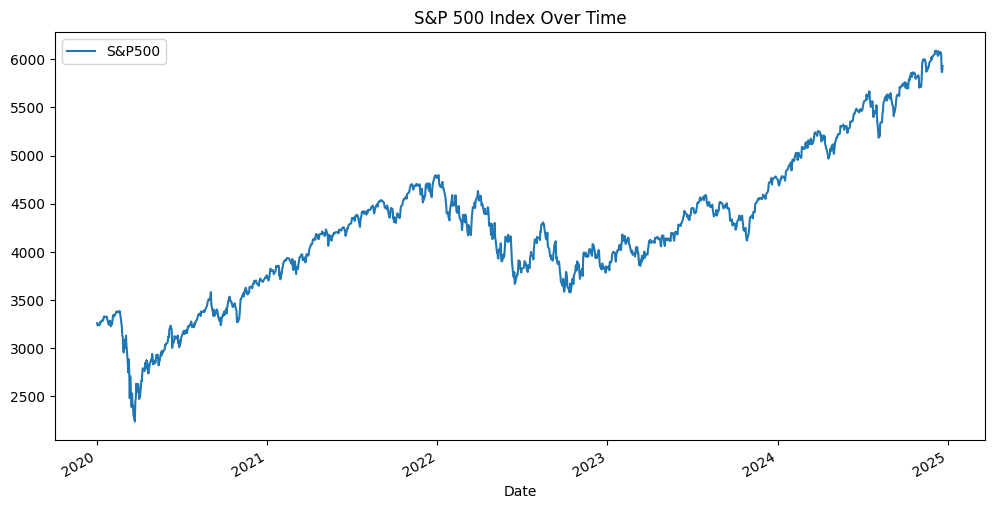

In [ ]:
ax = index_5_df.plot(
    y='S&P500',
    figsize=(12,6),
    title='S&P 500 Index Over Time',
    grid=False
)

fig = ax.get_figure()
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

plt.show()

At first glance, it is very clear that the mean is **not constant** over time — the index shows a strong upward trend, suggesting non-stationarity. However, to investigate more carefully, we will plot its Autocorrelation Function (ACF) next

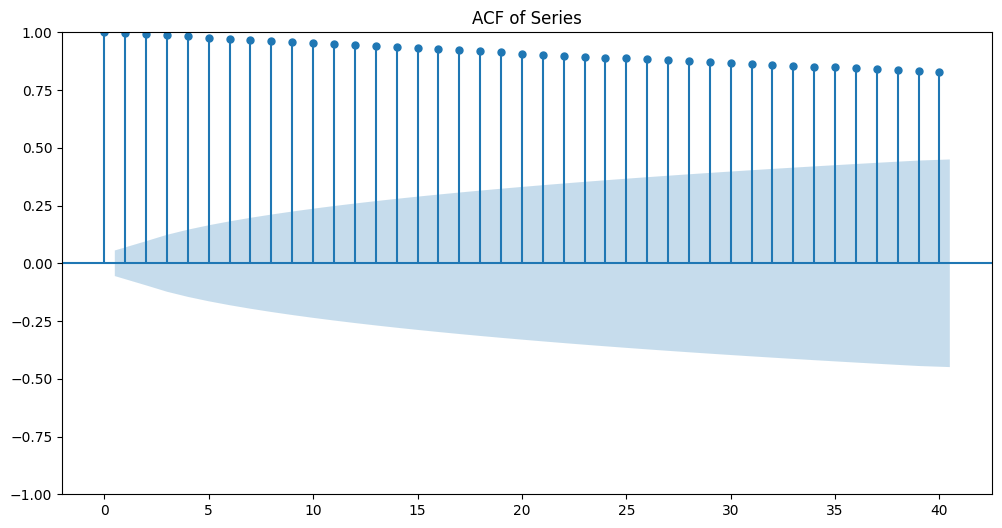

In [ ]:
# plot ACF
fig, ax = plt.subplots(figsize=(12,6))
plot_acf(index_5_df['S&P500'], lags=40, ax=ax)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.title('ACF of Series')
plt.show()

The Autocorrelation Function (ACF) provides a more quantitative way to assess stationarity. If the series is stationary, we expect the autocorrelations to drop off quickly.

After plotting the ACF of our S&P 500 data, we observe that the correlations remain **very high across many lags**, indicating strong persistence over time. This is another clear sign that the series is likely **non-stationary**.

To be fully sure, we will now perform a statistical test: the Augmented Dickey-Fuller (ADF) test.


In [ ]:
adf_original_result = adfuller(index_5_df['S&P500'].dropna())

# print results
print('ADF Statistic:', adf_original_result[0])
print('p-value:', adf_original_result[1])
print('Critical Values:')
for key, value in adf_original_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -0.2585978036101119
p-value: 0.9311668789820153
Critical Values:
   1%: -3.435630320520318
   5%: -2.863871779019612
   10%: -2.56801146937726


 Since the **p-value** is very high (0.9312 > 0.05), we **fail to reject the null hypothesis** that the series has a unit root.
- In simple terms: **the S&P 500 series is non-stationary**.

To address the non-stationarity observed earlier, we applied a **first-order differencing** to the S&P 500 series. Differencing helps stabilize the mean by removing the long-term upward trend.

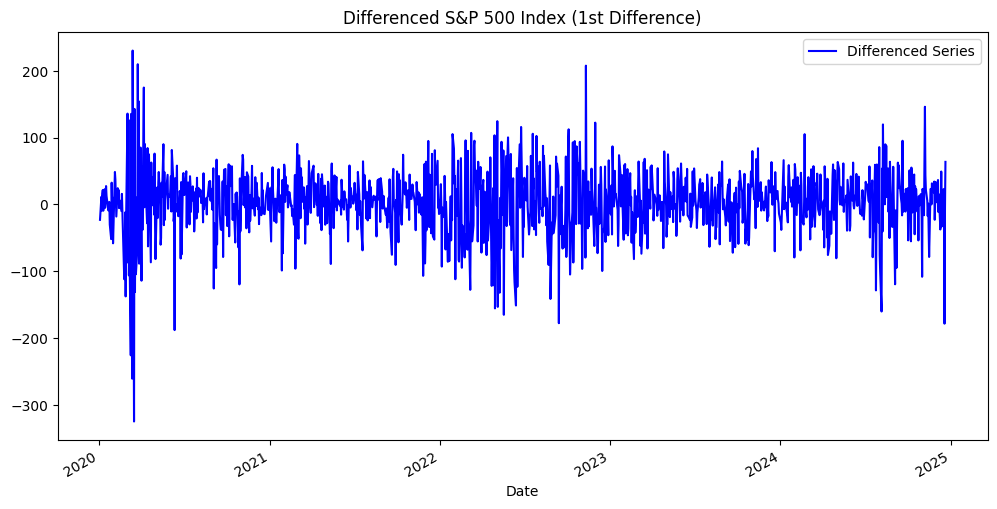

In [ ]:
# 1st order differencing
differenced = index_5_df['S&P500'].diff().dropna()

# plot the differenced series
fig, ax = plt.subplots(figsize=(12,6))
differenced.plot(ax=ax, color='blue', label='Differenced Series')
ax.set_title('Differenced S&P 500 Index (1st Difference)')
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.legend()
plt.show()

At first glance, the differenced series looks much more stationary:
- The mean now appears roughly constant over time.
- The variance seems more stable across the entire series.
- No obvious trend or seasonal pattern is present.

However, while the visual impression is encouraging, it is important to confirm stationarity more formally. Next, we will plot the Autocorrelation Function (ACF) of the differenced series to check for remaining patterns, and then rerun the ADF test to statistically validate whether our series is now stationary.

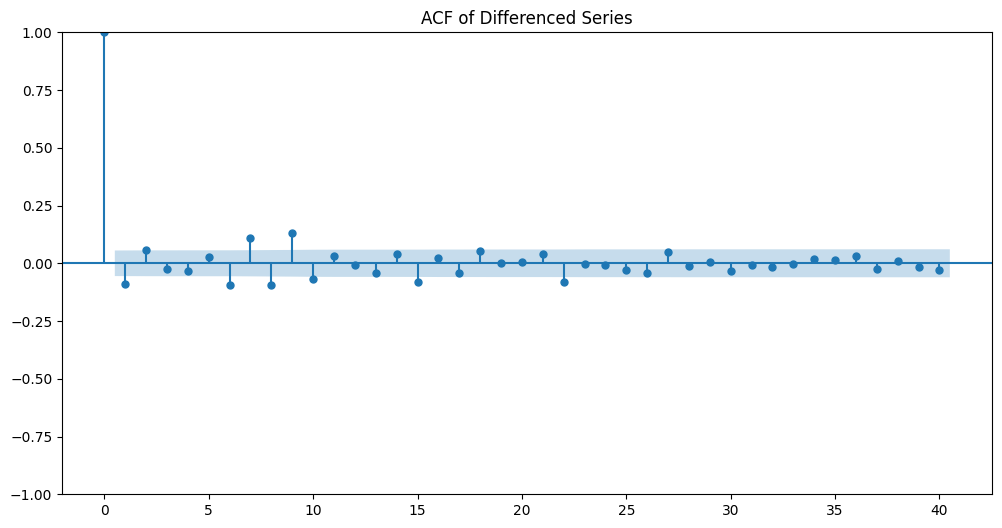

In [ ]:
# plot ACF
fig, ax = plt.subplots(figsize=(12,6))
plot_acf(differenced, lags=40, ax=ax)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.title('ACF of Differenced Series')
plt.show()

After applying first-order differencing, the ACF plot shows that autocorrelations drop off very quickly — staying mostly within the 95% confidence bounds after lag 0.

This behavior is characteristic of a stationary series:
- There are no strong correlations persisting across many lags.
- The series appears to have "short memory," meaning past values have little predictive power for future values beyond the very recent past.

Visually, this is another strong indicator that our differencing transformation has successfully stabilized the series.

To confirm, we will now perform the Augmented Dickey-Fuller (ADF) test once more to statistically verify that the series is stationary.

In [ ]:
# run the test
adf_result = adfuller(differenced)

# print the results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -11.067493393183673
p-value: 4.642031710717883e-20
Critical Values:
   1%: -3.435630320520318
   5%: -2.863871779019612
   10%: -2.56801146937726


After differencing the series once, we reran the Augmented Dickey-Fuller (ADF) test to statistically confirm stationarity.

Since the **ADF statistic is far below all critical values** and the **p-value is extremely small**, we can confidently **reject the null hypothesis** of a unit root.

✅ This confirms that the differenced S&P 500 series is now **stationary** — it has a constant mean, stable variance, and short memory.

We are now ready to proceed with modeling techniques such as ARMA or ARIMA, which assume stationarity.


# Modeling

Now that we have a stationary version of the S&P 500 series, we’re ready to move into the heart of time series analysis — **modeling**.

To begin building a model, we need to determine appropriate values for the model parameters:
- **p**: the order of the autoregressive (AR) term,
- **d**: the degree of differencing (which we’ve already applied),
- **q**: the order of the moving average (MA) term.

To identify suitable values for **p** and **q**, we analyze the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** of the **differenced series**.

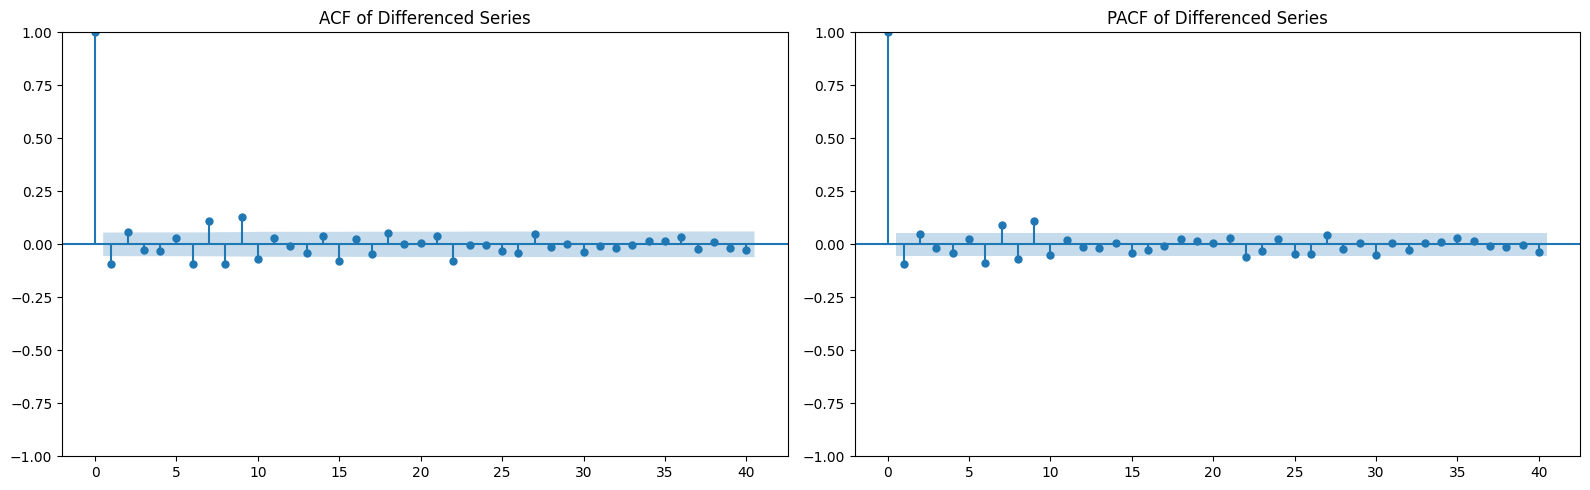

In [ ]:
# plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF
plot_acf(differenced, ax=axes[0], lags=40)
axes[0].set_title('ACF of Differenced Series')

# PACF
plot_pacf(differenced, ax=axes[1], lags=40, method='ywm')
axes[1].set_title('PACF of Differenced Series')

plt.tight_layout()
plt.show()

To begin modeling our stationary differenced data, we implement an ARMA model. Since we’ve already differenced the data to address non-stationarity, we set the integrated term, 𝑑 = 0, reducing our ARIMA model to a simpler ARMA model. Based on our ACF and PACF plots, we select an ARMA(1,1) structure, which includes one autoregressive term (AR(1)) and one moving average term (MA(1)).

In [ ]:
# build ARMA model
# (p,d,q) → d=0 because we already differenced

# (1,0,1)
arma_model = ARIMA(differenced, order=(1,0,1))  # (p,d=0,q)

# fit the model
arma_model_fit = arma_model.fit()

# print summary
arma_model_fit.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 S&P500   No. Observations:                 1251
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -6629.117
Date:                Tue, 29 Apr 2025   AIC                          13266.234
Time:                        14:54:50   BIC                          13286.761
Sample:                             0   HQIC                         13273.951
                               - 1251                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1361      1.351      1.582      0.114      -0.511       4.783
ar.L1         -0.4114      0.143     -2.872      0.004      -0.692      -0.131
ma.L1          0.3186      0.150      2.119      0.034       0.024       0.613
sigma2      2345.4151     60.428     38.814      0.000    2226.979    2463.851
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               762.08
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The summary output gives us a detailed look at the model parameters. Both the AR and MA terms are statistically significant (p-values < 0.05), indicating that past values and past forecast errors both contribute to predicting the current value. The Ljung-Box and Jarque-Bera tests suggest that residuals do not exhibit strong autocorrelation or significant departure from normality, supporting the validity of our model. Next, we move on to forecasting with this fitted ARMA(1,1) model.

Now that our ARMA model is trained, we generate a short-term forecast using the differenced data. This step projects the changes in the S&P 500 over the next 22 business days (~1 month), giving us insight into expected relative shifts rather than actual index values.



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


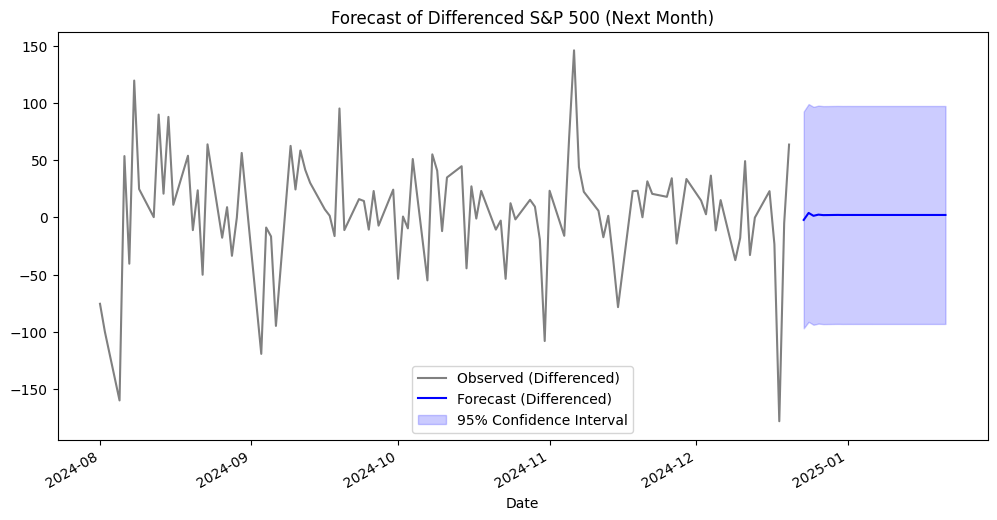

In [ ]:
# define the next 22 business days (about 1 month)
n_steps = 22

# 1. forecast
arma_forecast = arma_model_fit.get_forecast(steps=n_steps)

# 2. get forecasted mean and confidence intervals
forecast_mean = arma_forecast.predicted_mean
conf_int = arma_forecast.conf_int()

# 3. create future date range
last_date = differenced.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_steps, freq='B')

# reindex forecast to match future dates
forecast_mean.index = future_dates
conf_int.index = future_dates

# 4. plot
fig, ax = plt.subplots(figsize=(12,6))

# plot recent differenced data (last 100 days for context)
differenced.tail(100).plot(ax=ax, label='Observed (Differenced)', color='gray')

# plot forecasted differenced values
forecast_mean.plot(ax=ax, label='Forecast (Differenced)', color='blue')

# plot confidence intervals
ax.fill_between(forecast_mean.index,
                conf_int.iloc[:,0],
                conf_int.iloc[:,1],
                color='blue', alpha=0.2, label='95% Confidence Interval')

ax.set_title('Forecast of Differenced S&P 500 (Next Month)')
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.legend()
plt.show()

This plot visualizes the forecasted differenced values alongside recent historical changes. While helpful for understanding trends, differenced forecasts aren't intuitive in raw form. To make sense of these predictions in real S&P 500 index values, we must reverse the differencing process by cumulatively summing the forecasts and adding them back to the last known actual value.

To interpret our predictions on the original scale of the S&P 500 index, we convert the differenced forecast back to actual values. This involves cumulatively summing the predicted changes and adding them to the last known value from the original (undifferenced) series.

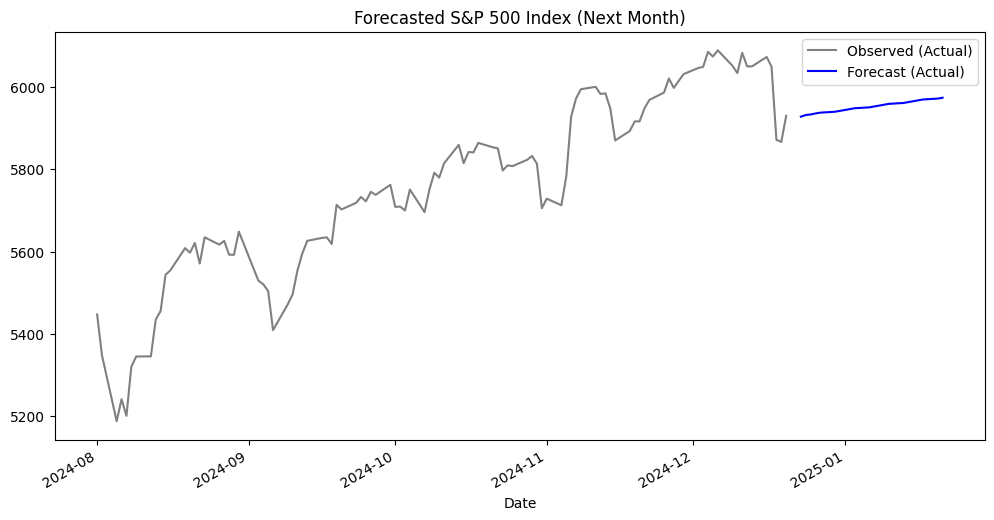

In [ ]:
# 1. get the previous (lag 1) S&P 500 value (before differencing)
last_actual_value = index_5_df['S&P500'].iloc[-1]

# 2. cumulatively sum the forecasted differences
forecast_cumsum = forecast_mean.cumsum()

# 3. add the last actual value to get forecasted actual values
forecast_actual = last_actual_value + forecast_cumsum

# 4. plot
fig, ax = plt.subplots(figsize=(12,6))

# plot the recent true S&P500 (last 100 days for context)
index_5_df['S&P500'].tail(100).plot(ax=ax, label='Observed (Actual)', color='gray')

# plot the forecasted actual S&P500
forecast_actual.plot(ax=ax, label='Forecast (Actual)', color='blue')

ax.set_title('Forecasted S&P 500 Index (Next Month)')
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.legend()
plt.show()

The final chart presents our forecast for the S&P 500 index over the next month, now on the original scale. The blue line projects a smooth upward trend, consistent with recent momentum in the index. This completes our ARMA(1,1) forecast pipeline — transforming the original data, modeling its structure, forecasting its future, and translating results back into meaningful financial terms.



# Conclusion
Through this time series analysis of the S&P 500, we've explored various techniques—from smoothing and decomposition to building an ARMA model—for understanding and forecasting the market. While we observed valuable patterns such as post-COVID recovery, inflation-induced dips, and more recent rebounds, modeling the S&P 500 remains extremely challenging.

The S&P 500 is influenced by countless unpredictable, external factors—macroeconomic conditions, geopolitical events, investor sentiment, and sudden shocks—that cannot be fully captured in historical price data alone. This complexity introduces volatility, non-linearity, and noise, making it difficult for even advanced models to consistently forecast accurately.

Our models provide short-term insight and direction, but their predictive power fades with time. Simple methods like moving averages offer helpful trend smoothing but lag in rapidly shifting markets.

Ultimately, while time series models help us understand patterns and make short-term predictions, the S&P 500 is only partially predictable. Markets follow some structure, but there’s a lot of randomness too—reminding us why financial forecasting is hard, and why people get paid so much to try.

